# Radial Basis Function Neural Network

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
sys.path.insert(0,'../')

In [2]:
from itertools import product
import pickle

import numpy as np
import matplotlib.pyplot as plt

from system_identification.rbfnn_model import RadialBasisFunctionNeuralNetworkModel

## 1D

In [3]:
def foo(x):
    return -x**2


inputs = np.linspace(-1, 1, 1000)
reference_outputs = np.array(list(map(foo, inputs)))
reference_outputs_noisy = reference_outputs + np.random.normal(0, 0.1, size=reference_outputs.shape)

inputs = inputs.reshape(-1, 1, 1)
reference_outputs = reference_outputs.reshape(-1, 1, 1)
reference_outputs_noisy = reference_outputs_noisy.reshape(-1, 1, 1)

### Least squares

In [4]:
model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
    n_inputs=1,
    grid_size=[9],
    input_range=np.array([(-1, 1)]),
    rbf_width=1.75,
    rbf_amplitude=1,
)
model

<RadialBasisFunctionNeuralNetwork
 n_inputs=1
 n_hidden=9
 n_outputs=1>

In [5]:
model.train(inputs, reference_outputs_noisy)

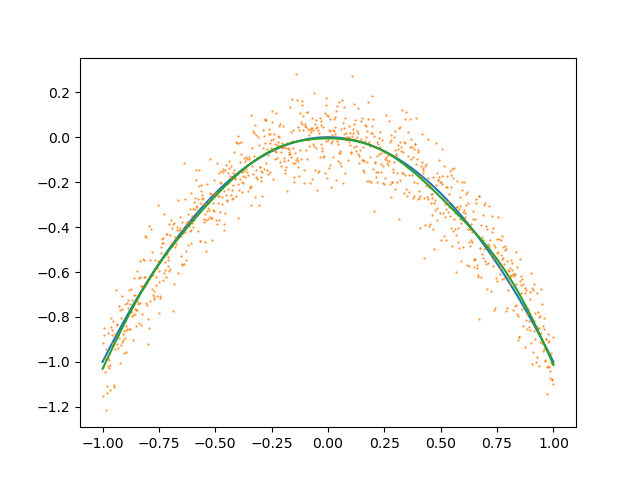

In [6]:
fig = plt.figure()
outputs = model.evaluate(inputs)
plt.plot(inputs.squeeze(), reference_outputs.squeeze())
plt.plot(inputs.squeeze(), reference_outputs_noisy.squeeze(), ".", markersize=1)
plt.plot(inputs.squeeze(), outputs.squeeze())

### Levenberg-Marquardt training

In [7]:
model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
    n_inputs=1,
    grid_size=[3],
    input_range=np.array([(-1, 1)]),
    rbf_width=3,
    rbf_amplitude=1,
)

In [8]:
model

<RadialBasisFunctionNeuralNetwork
 n_inputs=1
 n_hidden=3
 n_outputs=1>

In [9]:
model.train(
    inputs,
    reference_outputs,
    epochs=1000,
    goal=1e-6,
    train_log_freq=1,
    method="trainlm",
    mu=10.,
    alpha=0.95
)

  0%|          | 0/1000 [00:00<?, ?it/s]

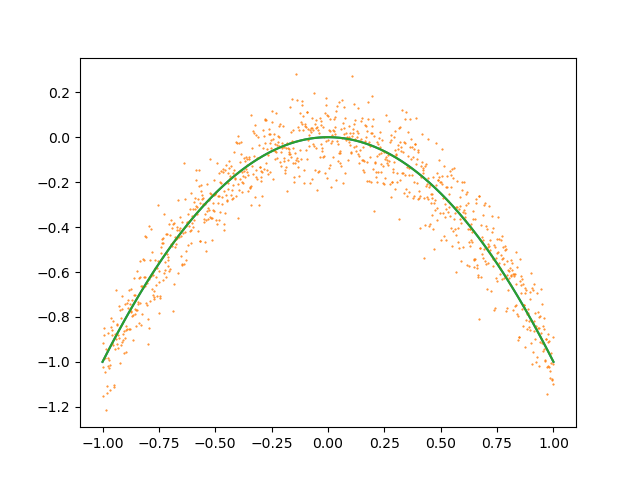

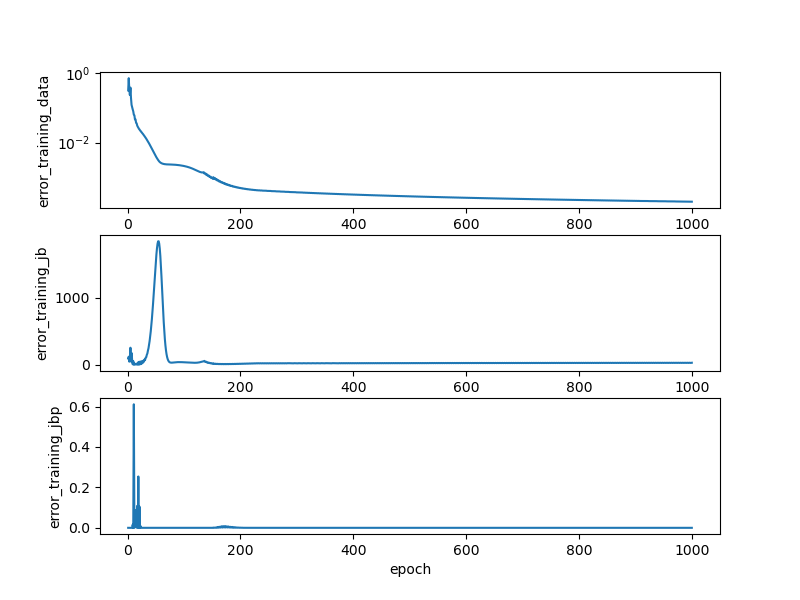

In [10]:
fig = plt.figure()
outputs = model.evaluate(inputs)
plt.plot(inputs.squeeze(), reference_outputs.squeeze())
plt.plot(inputs.squeeze(), reference_outputs_noisy.squeeze(), ".", markersize=1)
plt.plot(inputs.squeeze(), outputs.squeeze())

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
abs(model.training_log.error_training_data).mean("i").plot(ax=axs[0])
axs[0].set_yscale("log")
model.training_log.error_training_jb.plot(ax=axs[1])
model.training_log.error_training_jbp.plot(ax=axs[2])

## 2D

In [11]:
def foo(x):
    return -x[0]**2 + np.sin(x[1]*2)


resolution = 100
input_range = np.array([(-1, 1), (-3, 5)])
inputs = np.array(tuple(product(np.linspace(*input_range[0, :], resolution),
                                np.linspace(*input_range[1, :], resolution))))

reference_outputs = np.array(list(map(foo, inputs)))
reference_outputs_noisy = reference_outputs + (np.random.random(reference_outputs.shape) - 0.5) * 0.1

inputs = inputs[..., None]
reference_outputs = reference_outputs.reshape(-1, 1, 1)
reference_outputs_noisy = reference_outputs_noisy.reshape(-1, 1, 1)

### Least squares

In [12]:
model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
    n_inputs=2,
    grid_size=[5, 15],
    input_range=input_range,
    rbf_width=1.75,
    rbf_amplitude=1,
)
model

<RadialBasisFunctionNeuralNetwork
 n_inputs=2
 n_hidden=75
 n_outputs=1>

In [13]:
model.train(inputs, reference_outputs)
output = model.evaluate(inputs)

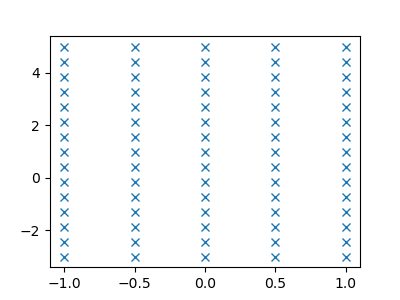

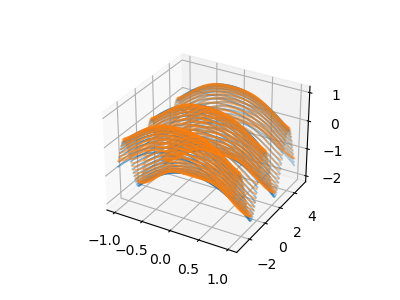

In [14]:
fig = plt.figure(figsize=(4, 3))
plt.plot(model.weights_c[:, 0], model.weights_c[:, 1], "x")

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], reference_outputs.squeeze(), s=0.1)
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], output.squeeze(), s=0.1)

### Levenberg-Marquardt training

In [15]:
model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
    n_inputs=2,
    grid_size=[5, 7],
    input_range=input_range,
    rbf_width=1.75,
    rbf_amplitude=1,
)
model

<RadialBasisFunctionNeuralNetwork
 n_inputs=2
 n_hidden=35
 n_outputs=1>

In [16]:
# Pretrain the network using least squares.
model.train(inputs, reference_outputs_noisy)

In [17]:
model.train(
    inputs,
    reference_outputs_noisy,
    epochs=30,
    goal=1e-6,
    train_log_freq=1,
    method="trainlm",
    mu=10.,
    alpha=0.95
)

  0%|          | 0/30 [00:00<?, ?it/s]

In [18]:
model.training_log

<xarray.Dataset>
Dimensions:                (epoch: 30, i: 10000, j: 1, k: 35, l: 35, m: 2,
                            n: 35, o: 2)
Coordinates:
  * epoch                  (epoch) int64 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30
Dimensions without coordinates: i, j, k, l, m, n, o
Data variables: (12/16)
    gradient               (epoch) float64 3.976e+04 4.496e+04 ... 5.317e+04
    error_training_data    (epoch, i) float64 -0.1002 -0.03859 ... -0.02307
    error_validation_data  (epoch, j) float64 nan nan nan nan ... nan nan nan
    error_training_jb      (epoch) float64 135.7 78.85 3.753 ... 314.3 331.2
    error_training_jbp     (epoch) float64 3.343e-30 7.566e-18 ... 1.219e-72
    error_training_skew    (epoch) float64 0.09029 0.1942 ... -0.03661 -0.03192
    ...                     ...
    error_validation_kurt  (epoch) float64 nan nan nan nan ... nan nan nan nan
    weights_a              (epoch, k) float64 -0.7649 -1.097 ... -0.152 -1.772
    weights_c              (epoch, l, m) float64 -0.9007 -3.033 ... 1.273 5.208
    weights_w              (epoch, n, o) float64 1.732 1.749 ... 1.397 1.206
    min_residual_epoch     float64 nan
    min_jb_epoch           float64 nan

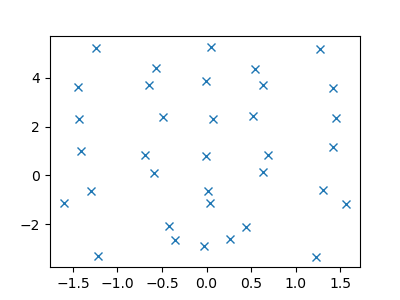

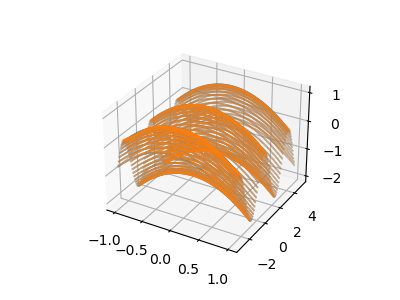

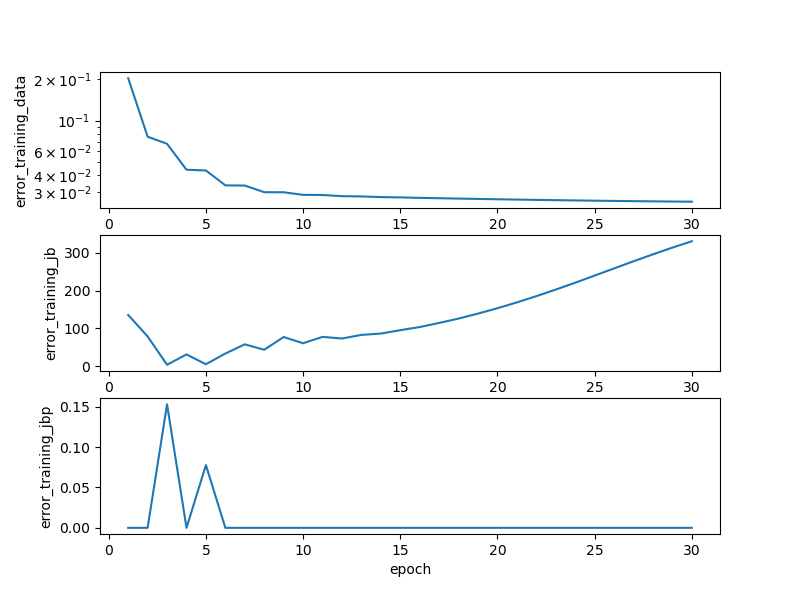

In [19]:
fig = plt.figure(figsize=(4, 3))
plt.plot(model.weights_c[:, 0], model.weights_c[:, 1], "x")

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(projection='3d')
output = model.evaluate(inputs)
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], reference_outputs.squeeze(), s=0.1)
ax.scatter(inputs[:, 0, 0], inputs[:, 1, 0], output.squeeze(), s=0.1)

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
abs(model.training_log.error_training_data).mean("i").plot(ax=axs[0])
axs[0].set_yscale("log")
model.training_log.error_training_jb.plot(ax=axs[1])
model.training_log.error_training_jbp.plot(ax=axs[2])

## Random within range RBF initialization.

In [20]:
model = RadialBasisFunctionNeuralNetworkModel.new_random_placement(
    n_inputs=2,
    n_hidden=4,
    input_range=input_range,
    width_range=(1.5, 2.5),
    amplitude_range=(0.5, 1.5),
)
model

<RadialBasisFunctionNeuralNetwork
 n_inputs=2
 n_hidden=4
 n_outputs=1>

In [21]:
# Check if the weights are within the given range.
assert (0.5 <= model.weights_a).all()
assert (1.5 >= model.weights_a).all()
assert (1.5 <= model.weights_w).all()
assert (2.5 >= model.weights_w).all()
assert (input_range[0, 0] <= model.weights_c[:, 0]).all()
assert (input_range[0, 1] >= model.weights_c[:, 0]).all()
assert (input_range[1, 0] <= model.weights_c[:, 1]).all()
assert (input_range[1, 1] >= model.weights_c[:, 1]).all()

## Centroidal Voronoi tessellation placement

In [22]:
model = RadialBasisFunctionNeuralNetworkModel.new_centroidal_voronoi_tessellation_placement(
    n_hidden=101,
    input_range=input_range,
    width_range=(1.5, 2.5),
    amplitude_range=(0.5, 1.5),
)
model

<RadialBasisFunctionNeuralNetwork
 n_inputs=2
 n_hidden=101
 n_outputs=1>

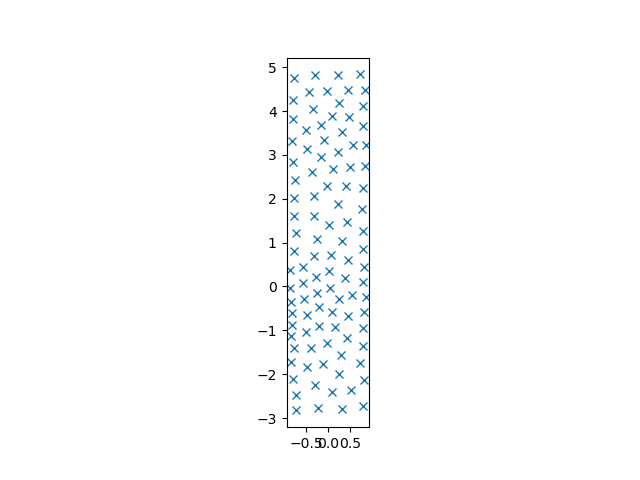

In [23]:
plt.figure()
plt.plot(model.weights_c[:, 0], model.weights_c[:, 1], "x")
plt.gca().set_aspect("equal")

## Pickling

In [24]:
model = RadialBasisFunctionNeuralNetworkModel.new_grid_placement(
    n_inputs=1,
    grid_size=[9],
    input_range=np.array([(-1, 1)]),
    rbf_width=1.75,
    rbf_amplitude=1,
)

In [25]:
pickled = pickle.dumps(model)

In [26]:
unpickled = pickle.loads(pickled)

In [27]:
unpickled

<RadialBasisFunctionNeuralNetwork
 n_inputs=1
 n_hidden=9
 n_outputs=1>